# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Превью

В данном проекте предстоит оценить 3 региона с месторождениями нефти и на основе полученных информации с помощью модели линейной регрессии предложить наиболее преспективный из них с точки зрения прибыли. Для каждого региона данные представлены в отдельной таблице. Названия полученных характеристик не известны, но это и не потребуется, достаточно будет числовых значений. Для начала рассмотрим представленные датасеты и осуществим визуальный анализ. Возможно не все данные нам потребуются для решения поставленной задачи. Разведоваться и осваиваться будут не все месторождения района, а лишь 5% и 2% лучших из них от общего количества. Произведем расчет предполагаемой прибыли для каждого региона на основании полученных предсказаний и выбранных месторождений. В целях более вероятного получения прибыли для поставленных условий воспользуемся техникой Bootstrap и оценим риски.   

## Загрузка и подготовка данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import shuffle
from scipy import stats as st
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState
import matplotlib.pyplot as plt

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647


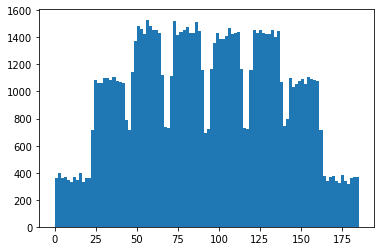

count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305
3,-13.081196,-11.506057,4.999415,137.945408
4,12.702195,-8.147433,5.004363,134.766305


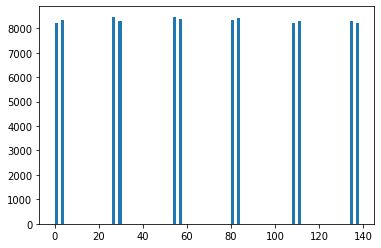

count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530187,56.069697
2,0.194587,0.289035,-5.586433,62.871910
3,2.236060,-0.553760,0.930038,114.572842
4,-0.515993,1.716266,5.899011,149.600746


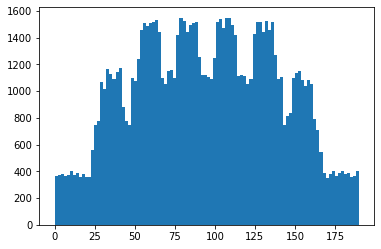

count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64


In [2]:
oilfield_1 = pd.read_csv('/datasets/geo_data_0.csv')
oilfield_2 = pd.read_csv('/datasets/geo_data_1.csv')
oilfield_3 = pd.read_csv('/datasets/geo_data_2.csv')
fields = [oilfield_1, oilfield_2, oilfield_3]
fields_new = []
for i in fields:
    i.info()
    i = i.drop('id', axis = 1)
    display(i.head())
    fields_new.append(i)
    plt.hist(i['product'], bins = 100)
    plt.show()
    print(i['product'].describe())

В рассматриветмых данных предобработка практически не понадобилась. Данные количественные и отсутствующих значений нет. Пришлось удалить лишь 1 столбец "id" с уникальными идентификаторами месторождений, для обучения он не потребуется, да и в дальнейшем не окажет никакого влияния на значения величин. Для связи значения целевого признака и исходных параметров используем индексы датасетов. В целях исключения повторения кода воспользовался циклом)Также проведен анализ распределения объемов нефти в скважинах по регионам и их характеристик. Для 2 датасета наблюдается не самая характерная картина. как будто кто то копал одинаковые скважины и заливал туда строго определенный объем нефти. Не похоже на природные процессы.

## Обучение и проверка модели

In [3]:
fields_name = ['oilfield_1', 'oilfield_2', 'oilfield_3']
list_m = []
list_metrics = []
c=0
for i in fields_new:
    target = i['product']
    features = i.drop('product', axis = 1)
    feature_train, feature_valid, target_train, target_valid = train_test_split(features, target,
                                                                                test_size = 0.25, random_state = 111) 
    model = LinearRegression(fit_intercept = True, normalize = True)
    model.fit(feature_train, target_train)
    predict = model.predict(feature_valid)
    list_m.append(fields_name[c])
    list_m.append(predict.mean())
    list_m.append(mean_squared_error(target_valid, predict)**0.5)
    list_metrics.append(list_m)
    list_m = []
    c += 1
fields_metrics = pd.DataFrame(data = list_metrics, columns = ['fields_name', 'mean', 'rmse'])    
display(fields_metrics)

,fields_name,mean,rmse
0,oilfield_1,92.290781,37.949371
1,oilfield_2,68.714059,0.888752
2,oilfield_3,95.101776,39.947731


В этом пункте, как и в предыдущем применен цикл для меньшего написания однотипного кода. В результате для каждого датасета таблица разделена на целевой и остальные признаки. Далее разделили их на тренировочные и валидационные выборки в соотношении 3:1, обучили и проверили на них модель, расчитали параметры среднего предсказанного значения объемов сырья для каждого месторождения, а также величину среднеквадратической ошибки. Данные свели в таблицу. Оказалось, что 1 и 3 регионы похожи по своим параметрам и имеют значительный средний запас сырья на одно месторождение. Однако данные в них не так предсказуемы, как этого хотелось и разброс значений составляем больше 40% для каждого из них. 2 регион серьезно уступает по средним запасам, но там где не копни, получишь примерно одинаковое количество нефти отколонение в предсказании составляем меньше 2%. Думаю имеет смысл рискнуть и попоробовать предсказать, в каком из двух более богатых регионов вероятнее найти 200 месторождений с наибольшими запасами нефти.  

## Подготовка к расчёту прибыли

In [4]:
budget = 10**10
price_bar = 4.5*10**5
exploration = 500
exploration_best = 200
profit_volume_1 = budget/(price_bar*exploration_best) 
print('Минимальный объем безубыточной прибыли', profit_volume_1)


Минимальный объем безубыточной прибыли 111.11111111111111


Все характеристики, которые могут понадобиться для расчетов сохранены. Произведен расчет безубыточности месторождения в баррелях. Данная величина оказалась больше среденего для каждого из регионов, а для 2 на целых 60%. Однако для данного региона наблюдается большой разброс объемов нефти в скважинах как в отрицательную так и в положитльную сторону от среднего значения. В 1 и 3 регионе придется наиболее оптимально подбирать месторождения для добывающих скважин. Гарантии прибыли нет и в этих регионах, и мы лишь сможем оценить вероятность благополучного исхода. В каком из регионов она будет выше, в том и будем добывать нефть. 

## Расчёт прибыли и рисков 

### Расчет прибыли

In [5]:
def profit_count(target, probabilities, count):
    predict_product_sorted = probabilities.sort_values(ascending=False)
    product_selected = target[predict_product_sorted.index][:count]
    profit_count_well = price_bar * product_selected.sum() - budget
    return profit_count_well


### Процедура Bootstrap и оценка рисков

In [6]:
state = RandomState(12345)
   
ki = 1
for k in fields_new:
    target = k['product']
    features = k.drop('product', axis = 1)
    feature_train, feature_valid, target_train, target_valid = train_test_split(features, target,
                                                                                test_size = 0.25, random_state = state) 
    model = LinearRegression(fit_intercept = True, normalize = True)
    model.fit(feature_train, target_train)
    predict = model.predict(feature_valid)
    target_valid_predict = pd.DataFrame(data=dict(target_valid = target_valid))
    target_valid_predict['predict'] = predict
    predict = target_valid_predict['predict']
        
    profit_values = []
    for i in range(1000):
        sample_500 = target_valid.sample(n = 500, random_state = state, replace = True) 
        sample_500_predict = predict[sample_500.index]
        profit_values.append(profit_count(sample_500, sample_500_predict, 200))
    
    profit_values = pd.Series(profit_values)
    probability_95_up =  profit_values.quantile(0.975)
    probability_95_low =  profit_values.quantile(0.025)
    risk =(profit_values < 0).mean()*100
    #risk = len(list(filter(lambda x: x - budget < 0, income_values)))*100/len(income_values)
    
    mean_profit = profit_values.mean()
    print("==================== Показатели региона", ki, "===========================")
    print("Для данного региона средняя прибыль равна", mean_profit.round(2))
    print("Для данного региона 95% доверительный интервал находится в диапазоне значений от",
          probability_95_low.round(2), "до", probability_95_up.round(2))
    print("Риски убытков для данного региона ", risk, '%\r\n', sep = '')
    ki += 1 

==================== Показатели региона 1 ===========================
Для данного региона средняя прибыль равна 426272370.77
Для данного региона 95% доверительный интервал находится в диапазоне значений от -126790034.59 до 983427683.72
Риски убытков для данного региона 6.800000000000001%

==================== Показатели региона 2 ===========================
Для данного региона средняя прибыль равна 509144419.15
Для данного региона 95% доверительный интервал находится в диапазоне значений от 103030263.74 до 948591900.54
Риски убытков для данного региона 1.2%

==================== Показатели региона 3 ===========================
Для данного региона средняя прибыль равна 345891112.84
Для данного региона 95% доверительный интервал находится в диапазоне значений от -188658819.97 до 875761830.88
Риски убытков для данного региона 9.8%



В ходе анализа оценки прибыли и рисков проведен расчет данных для контрольной выборки, которую формировали следующим образом: 
1. Случайно выбрираем из валидационной выборки 500 месторождений. 
2. Выбираем реальные значения запасов 200 из них с наибольшими предсказаными объемами нефти.
3. По формуле производим расчет прибыли с учетом данных из пункта 3. 

Оказалось, что 2 регион является наиболее прибыльным, регион 1 также приности значительный доход от вложений, а третий не такой доходный и приносит на 80 млн в среднем меньше прибыли, чем регион 1, и на 164 - чем регион 2. Оценил регионы используя технику Bootstrap. Выяснил, что самым рискованным с точни зрения получения прибыли является 3 регион и ее можно получить лишь с вероятностью чуть более 90%. При этом средняя выручка при проведении эксперемента с 1000 выборок получилась самой низкой. Наименее рискованным оказался 2 регион со странно распределенными по объему скважинами, всего 1.2%, а средняя прибыль с него наибольшая (509 млн). Регион 1 относительно 3 региона лучше по всем показателям, а по сравнению с регионом 2  хуже и по риску 6.8%, и по средней доходности (426 млн). На основе получившихся данных и условия задачи (риск региона должен быть менее 2,5%) предлагаю в качестве региона, где добыча принесёт наибольшую прибыль выбрать регион 2. 

## Вывод по работе

В данном проекте оценивал 3 региона с месторождениями нефти и на основе полученной информации с помощью модели линейной регрессии предлагал наиболее преспективный из них с точки зрения получения прибыли. Для датасета каждого региона предварительно произвел визуальный анализ, оценил обобщенные характеристики для целевого признака. Далее разделил таблицы на наборы данных с признаками и целевым признаком. Для каждого определил обучающую и валидационную выборку. Произвел обучение модели линейной регрессии и расчитал средний запас предсказанного сырья и RMSE модели. Оценил выборки с точки зрения полученных значений. Оказалось, что наиболее высокими средними запасами обладают регионы 3 и 1, а регион 2 значительно уступает им. В целях более вероятного получения прибыли для поставленных условий воспользовался техникой Bootstrap и оценил риски. По результатам применения этой процедуры самым рискованным регионом с наименьшей средней прибылью оказался регион 3, а в качестве наиболее целесообразного для разработки - регион 2 с показателями рисков 1.2% и средней прибылью освоения более 509 млн.    

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован